In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
raw = pd.read_excel('1-s2.0-S2352340918305092-mmc2.xlsx', sheet_name='Dataset with Generated Features')
df = raw.copy()
df.drop(['index', 'Material Composition', 'Formation_energy'], axis=1, inplace=True)
df.head()

,goldschmidt_TF,goldschmidt_TF_ionic,octahedral_factor,octahedral_factor_ionic,A_O,B_O,A_B,num_of_atoms_host_Asite0,shannon_radii_host_Asite0,host_Asite0_Ionic Radius (angstroms),...,Bsite_NdUnfilled_range,Bsite_NdValence_range,Bsite_NfUnfilled_range,Bsite_NfValence_range,Bsite_NpUnfilled_range,Bsite_NpValence_range,Bsite_NsUnfilled_range,Bsite_NsValence_range,Bsite_NUnfilled_range,EnergyAboveHull
0,1.021823,0.976828,0.414286,0.385714,2.86125,1.980,2.04125,7,1.440,1.26,...,0,0,0,0,0,0,0,0,0,29.747707
1,0.987385,0.889057,0.378571,0.464286,2.69500,1.930,1.82500,4,1.200,1.13,...,0,0,0,0,0,0,0,0,0,106.702335
2,0.976009,0.908360,0.452857,0.392857,2.80750,2.034,2.04150,6,1.340,1.00,...,0,0,0,0,0,0,0,0,0,171.608093
3,1.026809,0.865275,0.342857,0.492857,2.73000,1.880,1.81000,4,1.200,1.13,...,0,0,0,0,0,0,0,0,0,284.898190
4,0.909001,0.916519,0.452857,0.392857,2.61475,2.034,1.84875,6,1.083,1.03,...,0,0,0,0,0,0,0,0,0,270.007913


In [3]:
from sklearn.feature_selection import VarianceThreshold

# remove features with 0 variance
vt = VarianceThreshold()
vt.fit(df)
df = df.loc[:, vt.variances_ > 0 ]
df.shape

(1929, 792)

In [4]:
init_x = df.loc[:, df.columns !='EnergyAboveHull']
init_y = df.loc[:, 'EnergyAboveHull']

In [5]:
# remove low correlated features
low_corr = []
for col in init_x.columns:
    if abs(init_x[col].corr(init_y)) < 1e-2:
        low_corr.append(col)

In [6]:
from collections import defaultdict
corr_df = init_x.corr()
# get features that have correlation > 0.95 
def high_corr(corr):
    raw_corrs = defaultdict(float)
    for col in corr.columns:
        index = corr[col].index
        for pos in range(len(index)):
            if np.abs(corr[col][pos]) >= 0.90 and index[pos] != col:
                raw_corrs[(col, index[pos])] =  corr[col][pos]
    
    # remove duplicates by score
    result = defaultdict(float)
    for key,value in raw_corrs.items():
        if value not in result.values():
            result[key] = value
            
    return result

high_corrs = high_corr(corr_df)

In [7]:
# keep only one of the features that are highly correlated
# keep the one that has highest correlation with target
df.drop(low_corr, axis=1, inplace=True)

for key, val in high_corrs.items():
    try: 
        if np.abs(df[key[0]].corr(df['EnergyAboveHull'])) > np.abs(df[key[1]].corr(df['EnergyAboveHull'])):
            df = df.loc[:, df.columns != key[1]]
        else: 
            df = df.loc[:, df.columns != key[0]]
    except KeyError:
        continue
        
print(df.shape)

(1929, 397)


## Classification

In [8]:
class_df = df.copy()
class_df['class'] = class_df['EnergyAboveHull']
class_df['class'][class_df['EnergyAboveHull'] > 40] = 1
class_df['class'][class_df['EnergyAboveHull'] <= 40] = 0
class_df.drop(['EnergyAboveHull'], axis=1, inplace=True)
class_df.head()

/Users/williamyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/williamyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,octahedral_factor_ionic,num_of_atoms_host_Asite0,host_Asite0_BCCvolume_padiff,host_Asite0_HHIr,host_Asite0_At. Radius (angstroms),host_Asite0_MendeleevNumber,host_Asite0_Third Ionization Potential (V),host_Asite0_Coeficient of Thermal Expansion (10^-6 K-1),host_Asite0_electrical conductivity,host_Asite0_Heat of Vaporization,...,Bsite_OrbitalD_range,Bsite_Most stable oxidation State_range,Bsite_IsAlkali_range.1,Bsite_IsDBlock_range,Bsite_IsMetal_range,Bsite_IsMetalloid_range,Bsite_NfValence_range,Bsite_NsUnfilled_range,Bsite_NUnfilled_range,class
0,0.385714,7,-1.320,300,2.45,8,43.600,22.5,5.0,136.90,...,0,0,0,0,0,0,0,0,0,0.0
1,0.464286,4,0.215,310,2.67,17,21.620,5.4,1.5,332.63,...,0,0,0,0,0,0,0,0,0,1.0
2,0.392857,6,-0.950,150,2.23,7,50.908,22.3,31.3,154.67,...,0,0,0,0,0,0,0,0,0,1.0
3,0.492857,4,0.215,310,2.67,17,21.620,5.4,1.5,332.63,...,0,0,0,0,0,0,0,0,0,1.0
4,0.392857,6,-0.030,310,2.49,31,22.802,9.6,1.1,230.00,...,0,0,0,0,0,0,0,0,0,1.0


In [9]:
from sklearn.feature_selection import f_regression, f_classif, SelectKBest, RFECV, RFE
from sklearn.model_selection import train_test_split

X_class = class_df.loc[:, class_df.columns !='class']
y_class = class_df.loc[:, 'class']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class)

f_values, p_values = f_classif(X_train_class, y_train_class)

pval_df = pd.DataFrame({'features': X_class.columns, 'p_val': p_values})
pval_df = pval_df[pval_df['p_val'] >= 0.05]

class_df.drop(pval_df['features'], axis=1, inplace=True)
X_class.drop(pval_df['features'], axis=1, inplace=True)
X_train_class.drop(pval_df['features'], axis=1, inplace=True)
X_test_class.drop(pval_df['features'], axis=1, inplace=True)

/Users/williamyu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
import xgboost

In [11]:
# rfe feature select for classification
rfe = RFECV(GradientBoostingClassifier(random_state=0), scoring='f1')
rfe.fit(X_train_class, y_train_class)
print('Number of Features:',  rfe.n_features_)

Number of Features: 22


In [12]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
rfe_tree = RFECV(DecisionTreeClassifier(random_state=0), cv=StratifiedKFold(5, shuffle=True, random_state=0), scoring='f1')
rfe_tree.fit(X_train_class, y_train_class)
print('Number of Features:',  rfe_tree.n_features_)

Number of Features: 209


In [13]:
rfe_et_class = RFECV(ExtraTreesClassifier(random_state=0), cv=StratifiedKFold(5, shuffle=True, random_state=0), scoring='f1')
rfe_et_class.fit(X_train_class, y_train_class)
print('Number of Features:',  rfe_et_class.n_features_)

Number of Features: 273


In [16]:
X_gb = X_class.iloc[:, rfe.support_]
X_tree = X_class.iloc[:, rfe_tree.support_]
X_et_class = X_class.iloc[:, rfe_et_class.support_]

In [17]:
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_gb, y_class, random_state=0)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_class, random_state=0)
X_train_etc, X_test_etc, y_train_etc, y_test_etc = train_test_split(X_et_class, y_class, random_state=0)

In [43]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

xgb = xgboost.XGBClassifier(random_state=0)
xgb.fit(X_train_tree, y_train_tree)
y_pred_xgb = xgb.predict(X_test_tree)
print(f1_score(y_pred_xgb, y_test_tree, average='macro'))
print(classification_report(y_pred_xgb, y_test_tree))

0.9140989729225024
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87       125
         1.0       0.96      0.95      0.96       358

    accuracy                           0.93       483
   macro avg       0.91      0.92      0.91       483
weighted avg       0.93      0.93      0.93       483



In [30]:
# precision and recall both relatively low for stable compounds 
# imbalanced
y_class.value_counts()

1.0    1362
0.0     567
Name: class, dtype: int64

In [31]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

xgb = xgboost.XGBClassifier(random_state=0)
imb_pipe = make_imb_pipeline(RandomOverSampler(sampling_strategy=0.5, random_state=0), xgb)
imb_pipe.fit(X_train_tree, y_train_tree)
y_pred_xgb = imb_pipe.predict(X_test_tree)
print(f1_score(y_pred_xgb, y_test_tree, average='macro'))
print(classification_report(y_pred_xgb, y_test_tree))

0.9009307662884101
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85       126
         1.0       0.95      0.95      0.95       357

    accuracy                           0.92       483
   macro avg       0.90      0.90      0.90       483
weighted avg       0.92      0.92      0.92       483



In [32]:
# pretty similar results, slightly better
smote_pipe = make_imb_pipeline(SMOTE(random_state=0), xgboost.XGBClassifier(random_state=0))
smote_pipe.fit(X_train_tree, y_train_tree)
y_pred_xgb = smote_pipe.predict(X_test_tree)
print(f1_score(y_pred_xgb, y_test_tree, average='macro'))
print(classification_report(y_pred_xgb, y_test_tree))

0.9043353873239436
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       129
         1.0       0.95      0.95      0.95       354

    accuracy                           0.93       483
   macro avg       0.91      0.90      0.90       483
weighted avg       0.93      0.93      0.93       483



In [45]:
# final one
# training on 4 folds, evaluating on last fold = 80 20 split
cross_val = []
for i in range(20):
    cross_val.append(np.mean(cross_val_score(smote_pipe, X_tree, y_class, 
                                             cv=StratifiedKFold(10, shuffle=True, random_state=i), 
                                             scoring='f1_macro')))
np.mean(cross_val)

0.914134362470544

In [47]:
cross_val = []
xgb = xgboost.XGBClassifier(random_state=0)
for i in range(20):
    cross_val.append(np.mean(cross_val_score(xgb, X_tree, y_class, 
                                             cv=StratifiedKFold(10, shuffle=True, random_state=i), 
                                             scoring='f1_macro')))
np.mean(cross_val)

0.9099534110153412

In [49]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-for
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [50]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid = RandomizedSearchCV(ExtraTreesClassifier(random_state=0), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid.fit(X_train_tree, y_train_tree)
grid.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

In [51]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor
dt_pipe = make_imb_pipeline(SMOTE(random_state=0), 
                            ExtraTreesClassifier(random_state=0, n_estimators=600, max_depth=60))
np.mean(cross_val_score(dt_pipe, X_tree, y_class, cv=StratifiedKFold(5, shuffle=True, random_state=0), scoring='accuracy'))

0.9180808828477222

In [52]:
random_grid = {'extratreesclassifier__n_estimators': n_estimators,
               'extratreesclassifier__max_features': max_features,
               'extratreesclassifier__max_depth': max_depth,
               'extratreesclassifier__min_samples_split': min_samples_split,
               'extratreesclassifier__min_samples_leaf': min_samples_leaf,
               'extratreesclassifier__bootstrap': bootstrap}
pipe = make_imb_pipeline(RandomOverSampler(sampling_strategy=0.5, random_state=0), ExtraTreesClassifier(random_state=0))
grid_etc = RandomizedSearchCV(pipe, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
grid_etc.fit(X_et_class, y_class)
grid_etc.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.9min finished


{'extratreesclassifier__n_estimators': 600,
 'extratreesclassifier__min_samples_split': 5,
 'extratreesclassifier__min_samples_leaf': 1,
 'extratreesclassifier__max_features': 'auto',
 'extratreesclassifier__max_depth': 80,
 'extratreesclassifier__bootstrap': True}

In [53]:
dt_pipe = make_imb_pipeline(RandomOverSampler(random_state=0), 
                            ExtraTreesClassifier(random_state=0, n_estimators=1600, max_depth=10))
np.mean(cross_val_score(dt_pipe, X_et_class, y_class, cv=StratifiedKFold(10, shuffle=True, random_state=0), scoring='accuracy'))

0.921691493955095

## Regression

In [93]:
X_reg = df.loc[:, df.columns !='EnergyAboveHull']
y_reg = df.loc[:, 'EnergyAboveHull']

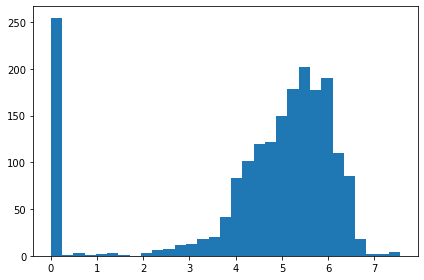

In [94]:
# apply inverse hyperbolic sine transform to normalize data
# response variable is heavily skewed right
y_reg_log= y_reg.apply(lambda x: np.arcsinh(x))
plt.hist(y_reg_log, bins='auto')
plt.tight_layout()

In [95]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg_log)

# remove statistically insignificant features based on lin reg
f_values, p_values = f_regression(X_train_reg, y_train_reg)
pval_df = pd.DataFrame({'features': X_reg.columns, 'p_val': p_values})
pval_df = pval_df[pval_df['p_val'] >= 0.05]

X_reg.drop(pval_df['features'], axis=1, inplace=True)
X_reg.shape

/Users/williamyu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1929, 314)

In [96]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg_log)
rfe_log = RFECV(DecisionTreeRegressor(random_state=0), cv=KFold(10, shuffle=True), scoring='r2')
rfe_log.fit(X_train_reg, y_train_reg)
print('Number of Features:',  rfe_log.n_features_)

Number of Features: 230


In [97]:
X_dtr_log = X_reg.iloc[:, rfe_log.support_]
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_dtr_log, y_reg_log, random_state=0)

In [98]:
dt = xgboost.XGBRegressor(random_state=0, max_depth=5)
dt.fit(X_train_log, y_train_log)
dt.score(X_test_log, y_test_log)

0.7852117513367863

In [99]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid = RandomizedSearchCV(ExtraTreesRegressor(random_state=0), param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
grid.fit(X_train_log, y_train_log)
grid.best_params_
grid.score(X_test_log, y_test_log)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 33.0min finished


0.8049043986342161

In [100]:
tree = ExtraTreesRegressor(random_state=0, max_depth=90, n_estimators=400, min_samples_split=5, min_samples_leaf=1,
                          max_features='auto', bootstrap=False)
tree.fit(X_train_log, y_train_log)
tree.score(X_test_log, y_test_log)

0.8081525413990637

In [101]:
# rfecv with extratrees
rfe_et = RFECV(ExtraTreesRegressor(random_state=0), cv=KFold(10, shuffle=True), scoring='r2', n_jobs=4)
rfe_et.fit(X_train_reg, y_train_reg)
print('Number of Features:',  rfe_et.n_features_)

Number of Features: 236


In [102]:
X_et = X_reg.iloc[:, rfe_et.support_]
X_train_et, X_test_et, y_train_et, y_test_et = train_test_split(X_et, y_reg_log, random_state=0)

In [103]:
#0.8167
grid = RandomizedSearchCV(ExtraTreesRegressor(random_state=0), param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
grid.fit(X_train_et, y_train_et)
grid.best_params_
grid.score(X_test_et, y_test_et)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 28.9min finished


0.8078767485858055

Text(0.5, 15.0, 'EnergyAboveHull')

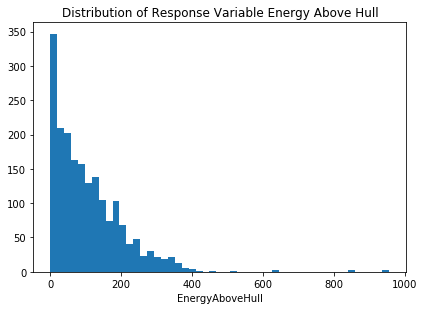

In [119]:
plt.hist(y_reg, bins='auto')
plt.tight_layout()
plt.title('Distribution of Response Variable Energy Above Hull')
plt.xlabel('EnergyAboveHull')

([<matplotlib.axis.XTick at 0x137f89860>,
 <a list of 2 Text xticklabel objects>)

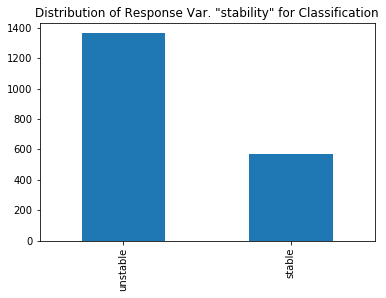

In [124]:
y_class.value_counts().plot.bar()
plt.title('Distribution of Response Var. "stability" for Classification')
plt.xticks(np.arange(2), ['unstable', 'stable'])

In [115]:
y_class.value_counts()

1.0    1362
0.0     567
Name: class, dtype: int64